### Weighted Control Kappa Map


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo

# Load your pairs DataFrame (replace filename if needed)

separation = 5
df = pd.read_csv(f"data/galaxy_pairs_catalog_{separation}hmpc.csv")

# Convert degrees to radians
l1 = np.radians(df["l1"])
b1 = np.radians(df["b1"])
l2 = np.radians(df["l2"])
b2 = np.radians(df["b2"])

# Angular separation (radians)
cos_theta = np.sin(b1) * np.sin(b2) + np.cos(b1) * np.cos(b2) * np.cos(l1 - l2)
theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # clip to avoid rounding errors

# Transverse separation
df["r_perp"] = theta * df["Dmid"]

# Save out
print("r_perp has", len(df), "rows")

import numpy as np
import pandas as pd

# Load r_perp values
r_perp = df["r_perp"].values

# Create 10 equal-width bins from min to max
n_bins = 10
bins = np.linspace(r_perp.min(), r_perp.max(), n_bins + 1)  # 21 edges

# Digitize values into bins
bin_indices = np.digitize(r_perp, bins) - 1  # subtract 1 to make 0-based indexing

# Count how many values are in each bin
counts = np.array([np.sum(bin_indices == i) for i in range(n_bins)])

# Print results
for i in range(n_bins):
    print(f"Bin {i}: {bins[i]:.3f} - {bins[i+1]:.3f}, count = {counts[i]}")

count_pct = counts / len(r_perp)
print(count_pct)

r_perp has 6549 rows
Bin 0: 4.000 - 4.200, count = 599
Bin 1: 4.200 - 4.400, count = 626
Bin 2: 4.400 - 4.600, count = 664
Bin 3: 4.600 - 4.800, count = 597
Bin 4: 4.800 - 5.000, count = 650
Bin 5: 5.000 - 5.200, count = 670
Bin 6: 5.200 - 5.400, count = 665
Bin 7: 5.400 - 5.600, count = 711
Bin 8: 5.600 - 5.800, count = 666
Bin 9: 5.800 - 6.000, count = 700
[0.09146435 0.09558711 0.10138953 0.09115896 0.09925179 0.1023057
 0.10154222 0.10856619 0.10169492 0.10688655]


In [6]:
def get_control_map(separation, center):
    box_size_hmpc = 100.0
    h = cosmo.h
    grid_size = 100
    cell_size_hmpc = box_size_hmpc / grid_size

    # --- Make Control Pair Map (±10 Mpc/h peaks) ---
    shift_hmpc = separation/2
    shift_pix = int(np.round(shift_hmpc / cell_size_hmpc))  # convert to pixels

    # Take the single-galaxy stacked κ map (already symmetrized if desired)
    base_map = center  # or kappa_smooth or kappa_sub, depending on what you want

    # Shift left and right
    map_left  = np.roll(base_map, -shift_pix, axis=1)  # shift to - Mpc/h
    map_right = np.roll(base_map, +shift_pix, axis=1)  # shift to + Mpc/h

    # Add them up to create a control "pair" map
    control = map_left + map_right
    return control

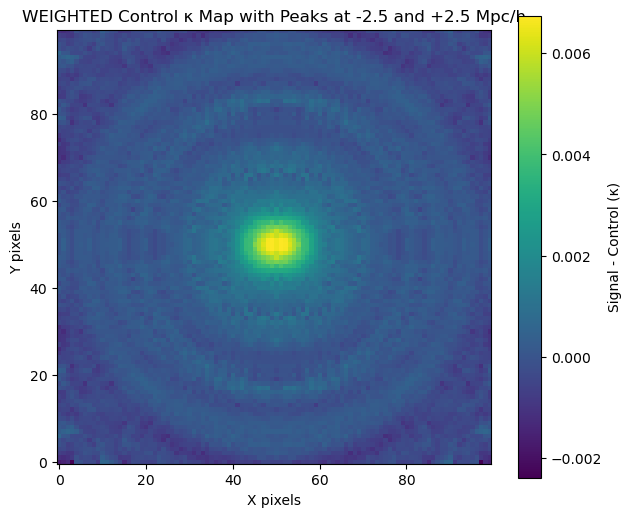

In [7]:
center = pd.read_csv("data/kappa_control_original.csv", index_col=0).values

for i in range(n_bins):
    sep = separation + i * 0.2
    control = get_control_map(sep, center)
    wt = count_pct[i]
    if i == 0:
        weighted_control = control * wt
    else:
        weighted_control += control * wt

plt.figure(figsize=(7, 6))
im = plt.imshow(weighted_control, origin="lower", cmap="viridis")
plt.colorbar(im, label="Signal - Control (κ)")
plt.title(f"WEIGHTED Control κ Map with Peaks at -{separation / 2} and +{separation / 2} Mpc/h")
plt.xlabel("X pixels")
plt.ylabel("Y pixels")
plt.show()

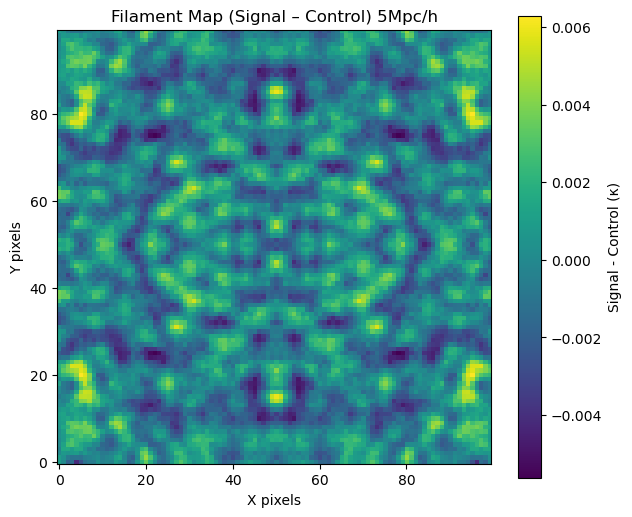

In [8]:
signal = pd.read_csv(f"data/kappa_sym_{separation}hmpc_NGCSGC.csv", index_col=0).values

# --- Crop to same shape if needed ---
min_size = min(signal.shape[0], weighted_control.shape[0])
signal = signal[:min_size, :min_size]
weighted_control = weighted_control[:min_size, :min_size]

filament = signal-weighted_control

plt.figure(figsize=(7, 6))
im = plt.imshow(filament, origin="lower", cmap="viridis")
plt.colorbar(im, label="Signal - Control (κ)")
plt.title(f"Filament Map (Signal – Control) {separation}Mpc/h")
plt.xlabel("X pixels")
plt.ylabel("Y pixels")
plt.show()